In [1]:
sentences = [
    "오늘 날씨가 좋아서 나들이 가고 싶다.", # -> [오늘, 날씨가, 좋아서 ...]
    "이 영화는 정말 재미있었어요.",
    "맛있는 음식을 먹으러 갈까요?",
    "운동을 하면 건강에 좋아지는 것 같아요.",
    "공부하기 싫어서 미루고 있어요.",
    "여행 계획을 세우고 있는데 어디로 갈까요?",
    "좋은 책을 읽으면 마음이 편안해져요.",
    "오늘은 친구들과 만나서 재미있게 놀았어요.",
    "새로운 언어를 배우는 것은 어려워도 흥미로워요.",
    "주말에 가족들과 함께 시간을 보내기로 했습니다."
]

In [2]:
# gensim 기능 사용 https://radimrehurek.com/gensim/apiref.html
from gensim.corpora import Dictionary

In [3]:
from gensim.models import LdaModel # 주제어 확인할 때 사용 LDA

### 전처리(형태소 분석, 불용어 처리 등이 들어감)


In [4]:
from mecab import MeCab

In [5]:
mecab=MeCab()

In [6]:
morphs_list = list()
for sentence in sentences :
    morphs = mecab.nouns(sentence)
    morphs_list.append(morphs)
morphs_list

[['날씨', '나'],
 ['영화'],
 ['음식'],
 ['운동', '건강', '것'],
 ['공부'],
 ['여행', '계획', '어디'],
 ['책', '마음', '편안'],
 ['오늘', '친구'],
 ['언어', '것', '흥미'],
 ['주말', '가족', '시간']]

In [7]:
preprocessed_sentences = morphs_list

In [8]:
dictionary=Dictionary(preprocessed_sentences) # .fit 과 동일. 

In [9]:
## gensim dictionary 하기 _ 단어의 vector를 자동화해줌
dictionary.token2id

{'나': 0,
 '날씨': 1,
 '영화': 2,
 '음식': 3,
 '건강': 4,
 '것': 5,
 '운동': 6,
 '공부': 7,
 '계획': 8,
 '어디': 9,
 '여행': 10,
 '마음': 11,
 '책': 12,
 '편안': 13,
 '오늘': 14,
 '친구': 15,
 '언어': 16,
 '흥미': 17,
 '가족': 18,
 '시간': 19,
 '주말': 20}

#### corpora.dictionary – Construct word<->id mappings
- classgensim.corpora.dictionary.Dictionary(documents=None, prune_at=2000000)
- from gensim.corpora import Dictionary
>- texts = [['human', 'interface', 'computer']]
>- dct = Dictionary(texts)  # initialize a Dictionary
>- dct.add_documents([["cat", "say", "meow"], ["dog"]])  # add more document (extend the vocabulary)
>- dct.doc2bow(["dog", "computer", "non_existent_word"])
[(0, 1), (6, 1)]

### transform with dictionary

In [10]:
dictionary.doc2bow(preprocessed_sentences[0]) # .transform 과 동일

[(0, 1), (1, 1)]

In [11]:
## vector화 시켜서 넣기 
corpus_list = list()
for sentence in preprocessed_sentences:
    morphs_vector = dictionary.doc2bow(sentence)
    corpus_list.append(morphs_vector)
corpus_list

[[(0, 1), (1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1)],
 [(8, 1), (9, 1), (10, 1)],
 [(11, 1), (12, 1), (13, 1)],
 [(14, 1), (15, 1)],
 [(5, 1), (16, 1), (17, 1)],
 [(18, 1), (19, 1), (20, 1)]]

In [12]:
lda_model=LdaModel(corpus=corpus_list, id2word=dictionary, num_topics=3 ) 
# 숫자에 해당하는 사전을 같이 넣어준다. = .fit
# LdaModel은 단어들을 집어넣고 나면 단어 하나당 나머지 token?단어를 비교한다. 

In [13]:
lda_model.print_topics(num_words=5)

[(0, '0.114*"가족" + 0.113*"시간" + 0.112*"주말" + 0.095*"공부" + 0.038*"음식"'),
 (1, '0.098*"책" + 0.097*"편안" + 0.097*"마음" + 0.094*"날씨" + 0.094*"나"'),
 (2, '0.118*"것" + 0.069*"언어" + 0.069*"여행" + 0.069*"건강" + 0.069*"계획"')]

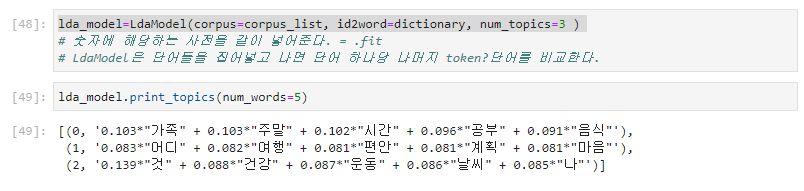
- lda_model=LdaModel(corpus=corpus_list, id2word=dictionary, num_topics=3 ) 
- 결과= topic 개수만큼! 0,1,2 이렇게 3개 나온것. 
- 그에 해당하는 num_words=5 의 결과가 5개 나온것. 순차적 나열임. 
    - 0: 주말 관련 keyword
    - 1: 여행 관련 keyword 
    - 2: 운동 관련 keyword
        - 결과의 숫자가 클수록 키워드가 강력한 것. 

## 최적에 토픽 단어 수

In [14]:
# 일관성 점수
from gensim.models.coherencemodel import CoherenceModel

In [19]:
coherencemodel=CoherenceModel(model=lda_model, texts=morphs_list, dictionary=dictionary)
coherencemodel.get_coherence()

0.7204797018632693

In [20]:
# 혼잡도 점수
lda_model.log_perplexity(corpus_list)

-4.092611818416091

In [45]:
start_topic = 2
end_topic = 10
coherence_scores = list()
perplexity_scores = list()
for topic_number in range(start_topic, end_topic+1) :
    lda_model=LdaModel(corpus=corpus_list, id2word=dictionary, num_topics=topic_number ) 
    coherencemodel=CoherenceModel(model=lda_model, texts=morphs_list, dictionary=dictionary)
    coherence_scores.append(coherencemodel.get_coherence()) # 일관성
    perplexity_scores.append(lda_model.log_perplexity(corpus_list))


In [46]:
import pandas as pd
scores=pd.DataFrame([coherence_scores, perplexity_scores])

In [47]:
import seaborn as sns
import matplotlib as plt

AttributeError: module 'matplotlib' has no attribute 'show'

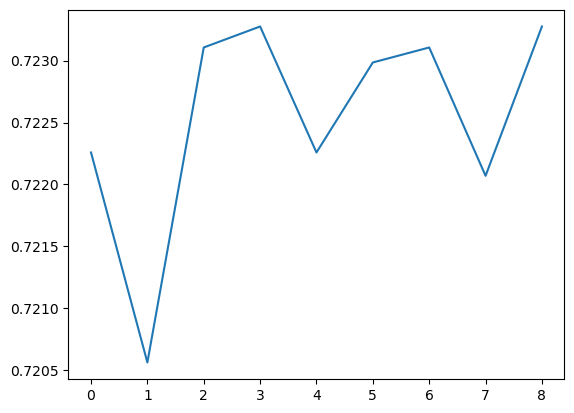

In [49]:
sns.lineplot(coherence_scores)
plt.show()
sns.lineplot(perplexity_scores)
plt.show()